# How does binarity change across primary mass?

Benjamin Pennell

December 24th, 2025

Max Planck Institut für Astronomie, Heidelberg

---

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from astropy.table import Table
import pickle
import pandas as pd
import SyntheticData as sd
import Sampler
import json

/home/bepennell/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


So, we have generated different soltype cubes for three different eccentricity models

In [2]:
sc_cubes_circular = pickle.load(open("./data/2025-12-19-mdwarf_mbins_3plx_circular.pkl", "rb"))
sc_cubes_thermal = pickle.load(open("./data/2025-12-19-mdwarf_mbins_3plx_thermal.pkl", "rb"))
sc_cubes_turnover = pickle.load(open("./data/2025-12-19-mdwarf_mbins_3plx_turnover.pkl", "rb"))
sc_cube_set = [sc_cubes_circular, sc_cubes_thermal, sc_cubes_turnover]
sc_cubes_singular = pickle.load(open("./data/2025-12-10-200pc_mdwarf_circular_3plx.pkl", "rb"))

In [3]:
t_loaded = Table.read('./data/200pc_mdwarfs_reduced.fits', format='fits')
all_mdwarfs = []
relevant_list = ["parallax", "mass", "solution_type"]
for row in tqdm(t_loaded): # we don't need every object, really 
    df = dict()
    for item in relevant_list:
        working_item = item
        if item == "mass":
            working_item = "mass_single"
        df[item] = float(row[working_item])
    all_mdwarfs.append(df)
    
percentiles = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])-5
masses = np.array([t["mass"] for t in all_mdwarfs])
mass_lims = np.percentile(masses, percentiles)

  0%|          | 0/260095 [00:00<?, ?it/s]

and, each of these cubes were generated for ten different mass bins. The aim - see how the expected binarity changes as primary masses change

Now, the storage of each cube is as follows
- `sc_cube["data"][mass][parallax]`

We will have to do some rearranging to get it into the format that works already with the code

In [4]:
def convert_to_usable(sc_cubes, mass_index):
    target_mass = sc_cubes["meta"]["reference_masses"][mass_index]
    
    out_sc_cube = {}
    out_sc_cube["data"] = sc_cubes["data"][target_mass]
    out_sc_cube["meta"] = {}
    out_sc_cube["meta"]["shape"] = sc_cubes["meta"]["shape"]
    out_sc_cube["meta"]["lambdas"] = np.array(sc_cubes["meta"]["lambdas"][mass_index])
    out_sc_cube["meta"]["periods"] = sc_cubes["meta"]["periods"]
    out_sc_cube["meta"]["parallaxes"] = sc_cubes["meta"]["parallaxes"]
    
    out_catalogue = []
    for i in range(3):
        out_catalogue = out_catalogue + sc_cubes["meta"]["memory_reduced_catalogue"][mass_index][i]

    # pull out only what we need
    memory_reduced = []
    relevant_list = ["parallax", "mass", "solution_type", "phot_g_mean_mag"]
    for row in out_catalogue: 
        df = dict()
        for item in relevant_list:
            working_item = item
            if item == "mass":
                working_item = "mass_single"
            df[item] = float(row[working_item])
        memory_reduced.append(df)
    
    return out_sc_cube, memory_reduced

### a first test

In [23]:
percentiles = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])-5
masses = np.array([t["mass"] for t in all_mdwarfs])
mass_lims = np.percentile(masses, percentiles)
    
def mass_binned_data(sc_cubes, catalogue, mass_binned=False, p_model=(4,2), q_model=0, model_cube_size=(15,15), scale=5):
    synth_results = []

    for mass_index in tqdm(range(len(mass_lims))):
        temp_catalogue = []
        for _, obj in enumerate(catalogue):
            if mass_index == 0:
                if obj["mass"] < mass_lims[0]:
                    temp_catalogue.append(obj)
            else:
                if (mass_lims[mass_index-1] < obj["mass"]) & (obj["mass"] < mass_lims[mass_index]):
                    temp_catalogue.append(obj)
        
        # reduce to only mandatory objects to save on memory
        working_catalogue = []
        relevant_list = ["parallax", "mass", "solution_type"]
        for row in temp_catalogue:
            df = dict()
            df["mass_index"] = mass_index
            for item in relevant_list:
                df[item] = float(row[item])
            working_catalogue.append(df)
        
        model_cube = Sampler.create_model_cube(model_cube_size, p_model=p_model, q_model=q_model)
        out_sc_cube = sc_cubes
        if mass_binned:
            out_sc_cube, _ = convert_to_usable(sc_cubes, mass_index)
        synthsampler = Sampler.popsampler(out_sc_cube, working_catalogue, model_cube=model_cube)
        _, _ = synthsampler.binarity(resolution=1000, scale=scale, verbose=False)
        synth_results.append(synthsampler.fb_estimator())
        print(synthsampler.fb_estimator()[0])
    synth_results = np.array(synth_results)
    return synth_results

def generate_plot(synth_results, target_fb=None):
    plt.errorbar(mass_lims, synth_results[:,0], yerr=(synth_results[:,2], synth_results[:,1]), fmt='none', capsize=5, ecolor='k', zorder=1);
    plt.scatter(mass_lims, synth_results[:,0], marker='o', zorder=2);
    if target_fb is not None:
        plt.axhline(y=target_fb, c="green", linestyle="--");

what we had before

In [13]:
with open('./massive_data/massive_samples.json', 'r') as fp:
    synthdata = json.load(fp)["data"][0]

  0%|          | 0/10 [00:00<?, ?it/s]

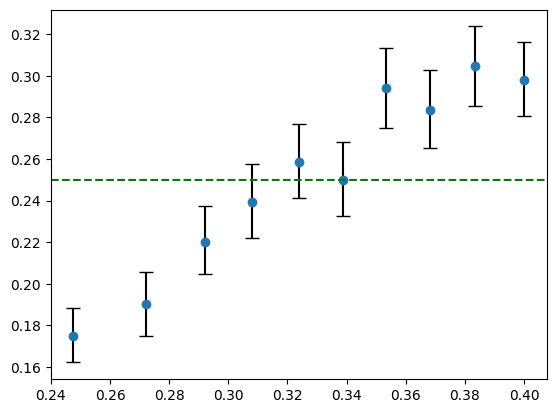

In [44]:
synth_results = mass_binned_data(sc_cubes_singular, synthdata, mass_binned=False, p_model=(4,2))
generate_plot(synth_results, target_fb=0.25)

and with the mass-binned version

  0%|          | 0/10 [00:00<?, ?it/s]

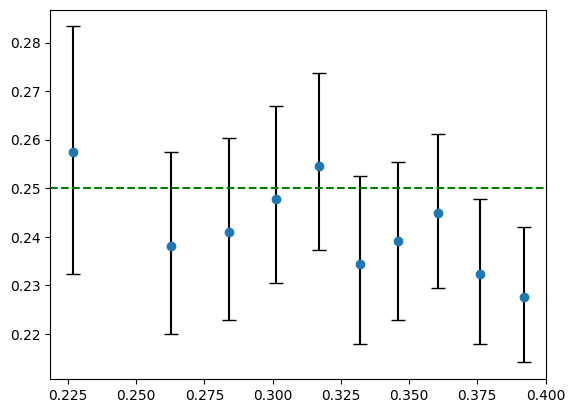

In [14]:
synth_results = mass_binned_data(sc_cubes_circular, synthdata, mass_binned=True, p_model=(4,2))
generate_plot(synth_results, target_fb=0.25)

In [72]:
np.mean(synth_results[:,0])

np.float64(0.25024624624624625)

and on the real data

In [ ]:
result_set = []
p_models = [(4,1.3), (4,2), (4,3), (5,2)]
for i, sc_cubes in enumerate(sc_cube_set):
    result_set.append([])
    for p_model in p_models:
        synth_results = mass_binned_data(sc_cubes, all_mdwarfs, mass_binned=True, p_model=p_model)
        result_set[i].append(synth_results)

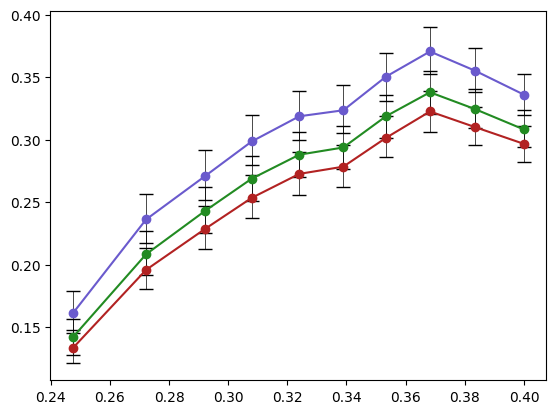

In [69]:
cols = ['firebrick', 'slateblue', 'forestgreen']
markers = ['o', '^', 's', 'X']
for i in range(3):
    for j in range(1):
        synth_results = result_set[i][j]
        plt.errorbar(mass_lims, synth_results[:,0], yerr=(synth_results[:,2], synth_results[:,1]), fmt='none', capsize=5, ecolor='k', zorder=1, linewidth=0.5);
        plt.plot(mass_lims, synth_results[:,0], marker=markers[j], color=cols[i], zorder=2); 

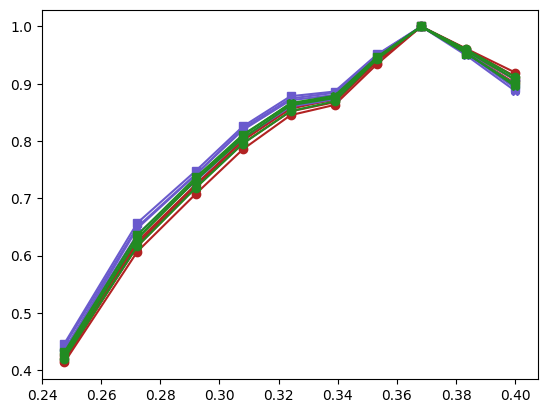

In [68]:
cols = ['firebrick', 'slateblue', 'forestgreen']
markers = ['o', '^', 's', 'X']
for i in range(3):
    for j in range(4):
        synth_results = result_set[i][j]
        #plt.errorbar(mass_lims, synth_results[:,0], yerr=(synth_results[:,2], synth_results[:,1]), fmt='none', capsize=5, ecolor='k', zorder=1, linewidth=0.5);
        plt.plot(mass_lims, synth_results[:,0]/np.max(synth_results[:,0]), marker=markers[j], color=cols[i], zorder=2); 

### a plot

In [12]:
data_exp = pickle.load(open("./massive_data/massive_samples_413_qexp.pkl", "rb"))["data"]

In [26]:
synth_results = mass_binned_data(sc_cubes_circular, data_exp, mass_binned=True, p_model=(4,1.3), q_model=0.5, model_cube_size=(25,10), scale=3)

  0%|          | 0/10 [00:00<?, ?it/s]

0.3275075075075075
0.29963963963963963
0.2986786786786787
0.2765765765765766
0.3102102102102102
0.2986786786786787
0.2957957957957958
0.29003003003003003
0.290990990990991
0.2977177177177177


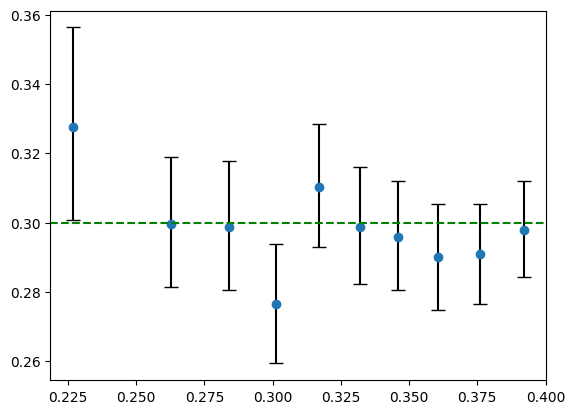

In [27]:
generate_plot(synth_results, target_fb=0.3)

  0%|          | 0/10 [00:00<?, ?it/s]

0.07778325881790368
0.06514956852887628
0.060941862641197234
0.056867130833594924
0.05575659707191869
0.05161994324517556
0.05026771842914705
0.050112146071793734
0.05010779619529837
0.050011516293188875


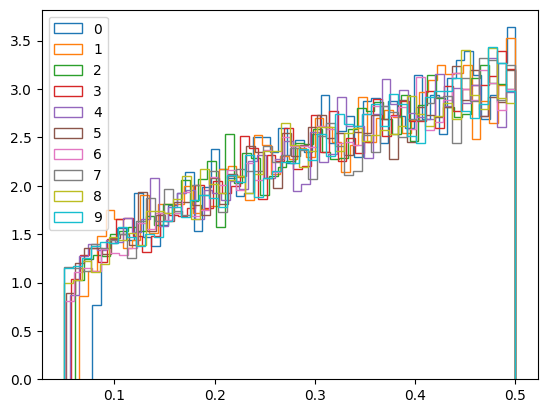

In [ ]:
counters = np.zeros(len(mass_lims))
orb_counters = np.zeros(len(mass_lims))
highr_counters = np.zeros(len(mass_lims))
for mass_index in tqdm(range(len(mass_lims))):
    counter = 0
    orb_counter = 0
    highr_counter = 0
    temp_catalogue = []
    binaries = []
    for _, obj in enumerate(data_exp):
        keep = False
        if mass_index == 0:
            if obj["mass"] < mass_lims[0]:
                keep = True
        else:
            if (mass_lims[mass_index-1] < obj["mass"]) & (obj["mass"] < mass_lims[mass_index]):
                keep = True
                
        if keep:
            temp_catalogue.append(obj)
            if obj["is_binary"]:
                binaries.append(obj)
                counter += 1
                if obj["solution_type"] > 0:
                    highr_counter += 1
                if obj["solution_type"] > 5:
                    orb_counter += 1
    #print(f'{counter/len(temp_catalogue)*100:.2f}, {highr_counter/len(temp_catalogue)*100:.2f}, {orb_counter/len(temp_catalogue)*100:.2f}')
    plt.hist([b["q"] for b in binaries], histtype="step", bins=50, density=True, label=mass_index);

    counters[mass_index] = counter
    orb_counters[mass_index] = orb_counter
    highr_counters[mass_index] = highr_counter
plt.legend();
#plt.plot(mass_lims, orb_counters/highr_counters, color="forestgreen");

In [36]:
outdata = dict()
outdata["meta"] = dict()
outdata["notes"] = "2026.01.12 413,q05 data (but the old cubes), scale=2, mass-binned binarity"
outdata["data"] = dict()
outdata["data"] = synth_results

outfile = open('./plot_data/main_result.pkl', "wb")
pickle.dump(outdata, outfile)
outfile.close()

### make plot

In [4]:
synth_results = pickle.load(open("./plot_data/main_result.pkl", "rb"))["data"]

In [5]:
a = Sampler.area_in_range_powerlaw((0.05,1), 0.5)/Sampler.area_in_range_powerlaw((0.05,0.5), 0.5)

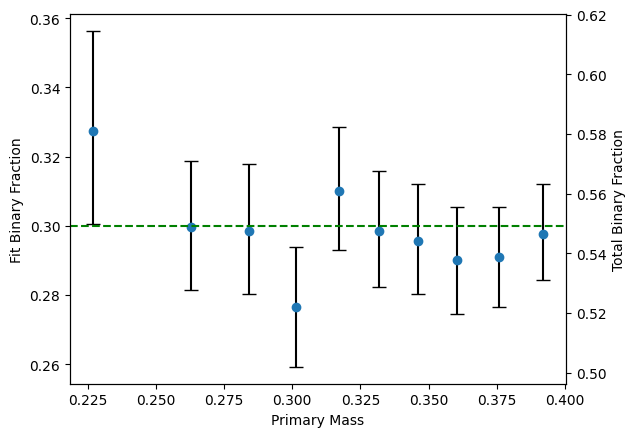

In [10]:
plt.errorbar(mass_lims, synth_results[:,0], yerr=(synth_results[:,2], synth_results[:,1]), fmt='none', capsize=5, ecolor='k', zorder=1);
plt.scatter(mass_lims, synth_results[:,0], marker='o', zorder=2);
plt.axhline(y=0.3, c="green", linestyle="--");
plt.xlabel("Primary Mass");
plt.ylabel("Fit Binary Fraction");
ymin, ymax = plt.ylim()
ax = plt.twinx();
ax.set_ylim(Sampler.convert_binarity(ymin, a), Sampler.convert_binarity(ymax, a));
ax.set_ylabel("Total Binary Fraction");